# MSP430 SCA

This code was developed to aid in performing a side channel attack (SCA) on AES128 encryption on an MSP430. Code from the following sources was either directly copied or used as an example for this code:
- https://wiki.newae.com/V4:Tutorial_B6_Breaking_AES_(Manual_CPA_Attack)
- Chatgpt

## Library Import

In [1]:
# for numpy array and plotting
import numpy as np
import matplotlib.pyplot as plt

# for list of plaintext
import os

# for converting from .mat to .py
import scipy.io as sio

# for program runtime
import time

## Data Preprocessing

### List plaintext

The goal of this section is to create a list of the plaintexts used for each power trace. This is so that the SCA algorithm knows which plaintext to use for each power trace when it computes the power consumed for Sbox lookup. In preliminary testing, we manually saved 10 power traces with 10 different plaintext values (not nearly enough, but needed for proof of concept). The 10 power traces are saved in the file that is given as the folder path, in this case 'C:/Users/ktrippe/OneDrive - University of Arkansas/Trulogic/SCA_AES/MSP430_sample_power_traces_mat_only'. 

*Important assumptions about the contents of the folder:*
- Only .mat files are included in the file
- Filenames follow this convention exactly: "plaintext + \_math1 (or some oscilloscope channel name) + .mat"

In [2]:
folder_path = 'C:/Users/ktrippe/OneDrive - University of Arkansas/Trulogic/SCA_AES/MSP430_sample_power_traces_mat_only_duplicates_three'

all_items = os.listdir(folder_path)

file_names = [item for item in all_items if os.path.isfile(os.path.join(folder_path, item))]

for filename in file_names:
    print(filename)
    
len(file_names)

3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy (2).mat
3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy (3).mat
3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy (4).mat
3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy.mat
3e2711fa9f3d4644788eaa2b0c521407_math1.mat
8a35ab20f269b4e766311ea50f81cb94_math1 - Copy (2).mat
8a35ab20f269b4e766311ea50f81cb94_math1 - Copy (3).mat
8a35ab20f269b4e766311ea50f81cb94_math1 - Copy (4).mat
8a35ab20f269b4e766311ea50f81cb94_math1 - Copy.mat
8a35ab20f269b4e766311ea50f81cb94_math1.mat
8c9c074b6f3e37d44b7fd6a9f6a52986_math1 - Copy (2).mat
8c9c074b6f3e37d44b7fd6a9f6a52986_math1 - Copy (3).mat
8c9c074b6f3e37d44b7fd6a9f6a52986_math1 - Copy (4).mat
8c9c074b6f3e37d44b7fd6a9f6a52986_math1 - Copy.mat
8c9c074b6f3e37d44b7fd6a9f6a52986_math1.mat


15

### Automated conversion from filenames to hex numbers

The plaintext values need to be given as two-byte hex numbers represented as binary numbers in the SCA algorithm. The following code takes the plaintexts, currently stored as strings in the filenames, and converts them to the two-byte hex number in binary representation format. The file naming convention is listed in the explanation for "List plaintext" section, and is directly related to the automatic generation of plaintext values. If the naming convention is different, this section should be as well. 

In [3]:
def extract_hex_from_filename(filename):
    # Extract the hex number from the filename
    hex_number = filename.split('_')[0].split('.')[0]
    return hex_number

def hex_to_decimal(hex_str):
    # Parse the hex number into pairs
    hex_pairs = [hex_str[i:i+2] for i in range(0, len(hex_str), 2)]

    # Convert the pairs to decimal
    decimal_numbers = [int(pair, 16) for pair in hex_pairs]

    return decimal_numbers

textin_auto = []

for filename in file_names:
    # Extract hex number from filename
    hex_number = extract_hex_from_filename(filename)

    # Convert hex to decimal
    decimal_numbers = hex_to_decimal(hex_number)
    textin_auto.append(decimal_numbers)

    # print(f"Filename: {filename}, Hex: {hex_number}, Decimal: {decimal_numbers}")
    
textin_auto

[[62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7],
 [62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7],
 [62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7],
 [62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7],
 [62, 39, 17, 250, 159, 61, 70, 68, 120, 142, 170, 43, 12, 82, 20, 7],
 [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148],
 [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148],
 [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148],
 [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148],
 [138, 53, 171, 32, 242, 105, 180, 231, 102, 49, 30, 165, 15, 129, 203, 148],
 [140, 156, 7, 75, 111, 62, 55, 212, 75, 127, 214, 169, 246, 165, 41, 134],
 [140, 156, 7, 75, 111, 62, 55, 212, 75, 127, 214, 169, 246, 165, 41, 134],
 [140, 156, 7, 75, 111, 62, 55, 212, 75, 127, 214, 169, 246, 165, 41, 134],
 [140, 156, 7, 75, 111, 62,

### Conversion from .mat to .npy

Assuming the file contains only the .mat files with power traces, this code can be used to iterate through files and store the content in a numpy array of traces. At the end, a new array called averaged_traces is created that is meant to average sets of traces that belong to the same plaintext. The program is written to take the average of every {num_avg} traces, so traces belonging to the same plaintext should all be grouped together and each plaintext should have the same number of traces. In this example, there are 15 total traces with 3 distinct plaintexts, so 5 traces per plaintext. This is also seen in the filenames listed under "List plaintext."

In [4]:
mat_list = []
# num_avg is the number of traces per plaintext used to smooth out the power traces
num_avg = 5

for j in range(len(file_names)):
    mat = sio.loadmat('C:/Users/ktrippe/OneDrive - University of Arkansas/Trulogic/SCA_AES/MSP430_sample_power_traces_mat_only_duplicates_three/' + file_names[j])
    # print(mat)
    print("Loading file " + file_names[j])

    mat_load = [[element for element in upperElement] for upperElement in mat['data']]
    
    mat_temp = []
    length = len(mat_load) 
    i = 0
    # modifying the data to exclude power spikes included in the original data
    for i in range(2225300): 
        mat_temp.append(mat_load[i+97499][0])
    
    mat_list.append(mat_temp)
    print(f"-------- Iteration {j} Complete --------")
    
traces = np.array(mat_list) # convert the list to a NumPy array
print(f"Size of traces matrix: {traces.shape}")

reshaped_traces = traces.reshape(-1, num_avg, traces.shape[1])
averaged_traces = np.mean(reshaped_traces, axis=1)
print(f"Size of averaged_traces matrix: {averaged_traces.shape}")

Loading file 3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy (2).mat
-------- Iteration 0 Complete --------
Loading file 3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy (3).mat
-------- Iteration 1 Complete --------
Loading file 3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy (4).mat
-------- Iteration 2 Complete --------
Loading file 3e2711fa9f3d4644788eaa2b0c521407_math1 - Copy.mat
-------- Iteration 3 Complete --------
Loading file 3e2711fa9f3d4644788eaa2b0c521407_math1.mat
-------- Iteration 4 Complete --------
Loading file 8a35ab20f269b4e766311ea50f81cb94_math1 - Copy (2).mat
-------- Iteration 5 Complete --------
Loading file 8a35ab20f269b4e766311ea50f81cb94_math1 - Copy (3).mat
-------- Iteration 6 Complete --------
Loading file 8a35ab20f269b4e766311ea50f81cb94_math1 - Copy (4).mat
-------- Iteration 7 Complete --------
Loading file 8a35ab20f269b4e766311ea50f81cb94_math1 - Copy.mat
-------- Iteration 8 Complete --------
Loading file 8a35ab20f269b4e766311ea50f81cb94_math1.mat
-------- 

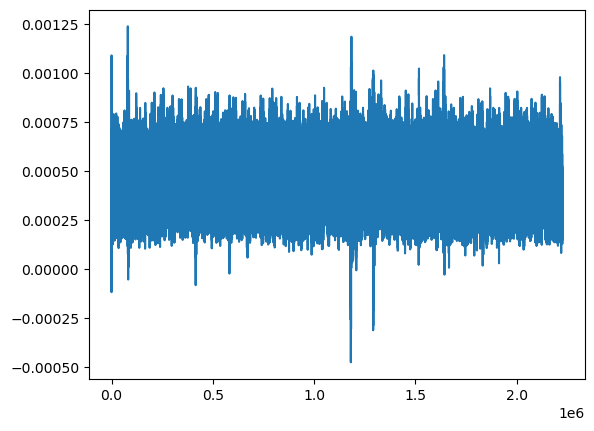

In [5]:
plt.plot(traces[0])
plt.show()

## SCA

### Sbox

The attack is being performed specifically on the power consumption during Sbox lookup, so the content of the Sbox is needed to compute an estimate of ideal power consumption.

In [6]:
#Lookup table for number of 1's in binary numbers 0-256
HW = [bin(n).count("1") for n in range(0,256)] 

sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

### Attack

This is where the attack is performed. All of the variables used here should be taken care of in data preprocessing.

In [7]:
def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]

pt = textin_auto
# traces = np.load(r'MSP430_sample_traces.npy')
# pt = np.load(r'MSP430_sample_textin.npy')

numtraces = np.shape(traces)[0]-1
numpoint = np.shape(traces)[1]

#Use less than the maximum traces by setting numtraces to something
#numtraces = 15

bestguess = [0]*16

start_time = time.time()
#Set 16 to something lower (like 1) to only go through a single subkey & save time!
for bnum in range(0, 2):
    cpaoutput = [0]*256
    maxcpa = [0]*256
    for kguess in range(0, 256):
        # print ("Subkey %2d, hyp = %02x: "%(bnum, kguess))


        #Initialize arrays & variables to zero
        sumnum = np.zeros(numpoint)
        sumden1 = np.zeros(numpoint)
        sumden2 = np.zeros(numpoint)

        hyp = np.zeros(numtraces)
        for tnum in range(0, numtraces):
            hyp[tnum] = HW[intermediate(pt[tnum][bnum], kguess)]


        #Mean of hypothesis
        meanh = np.mean(hyp, dtype=np.float64)

        #Mean of all points in trace
        meant = np.mean(traces, axis=0, dtype=np.float64)

        #For each trace, do the following
        for tnum in range(0, numtraces):
            hdiff = (hyp[tnum] - meanh)
            tdiff = traces[tnum,:] - meant

            sumnum = sumnum + (hdiff*tdiff)
            sumden1 = sumden1 + hdiff*hdiff 
            sumden2 = sumden2 + tdiff*tdiff

        cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )
        maxcpa[kguess] = max(abs(cpaoutput[kguess]))

        # print (maxcpa[kguess])

    #Find maximum value of key
    bestguess[bnum] = np.argmax(maxcpa)

print ("Best Key Guess: ")
for b in bestguess: 
    print ("%02x "%b)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed Time: {elapsed_time} seconds")

C:\Users\ktrippe\AppData\Local\Temp\ipykernel_19188\1738349863.py:50: RuntimeWarning: invalid value encountered in divide
  cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )


Best Key Guess: 
01 
20 
00 
00 
00 
00 
00 
00 
00 
00 
00 
00 
00 
00 
00 
00 
Elapsed Time: 510.34048342704773 seconds
